In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [40]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [53]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [55]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [56]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [58]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [59]:
# Display columns and types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [60]:
# Use engine.execute to display first 10 rows for display
engine.execute('SELECT * FROM measurement Limit 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [61]:
# Print column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [29]:
# Display first 10
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Precipitation Analysis

In [63]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


2016-08-23


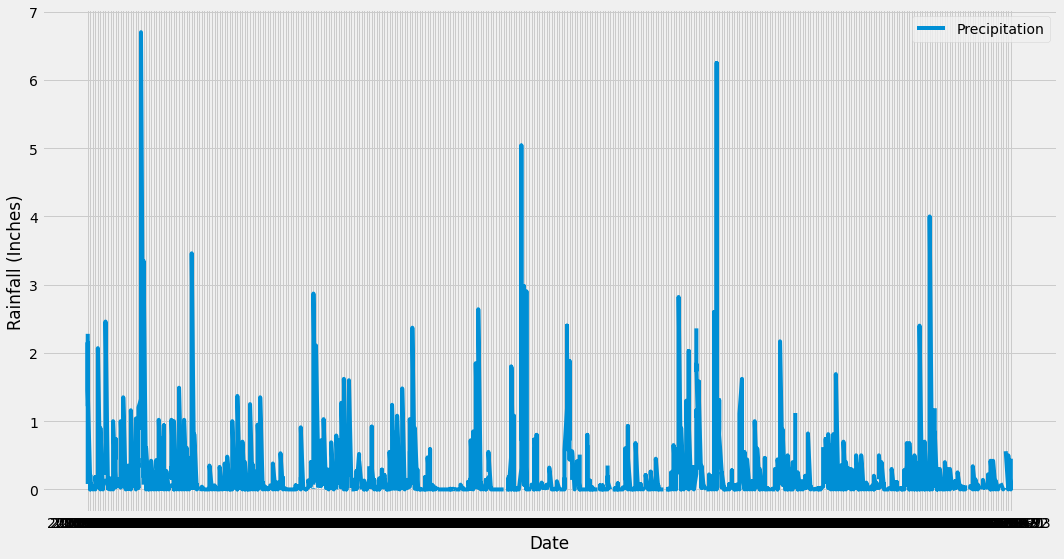

In [89]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > one_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=['date','prcp'])

# Sort the dataframe by date
prcp_df.set_index('date').head(10) 

# Use Pandas Plotting with Matplotlib to plot the data
df=pd.DataFrame(data=prcp_df)
plt.figure(figsize = (15,8))
plt.plot(df['date'], df['prcp'])
plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(['Precipitation'])
plt.tight_layout()
plt.show()

In [80]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [83]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [90]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

session.query(*sel).filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

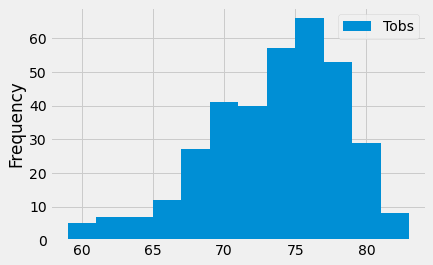

In [100]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(Measurement.tobs).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date >= one_year).\
    order_by(Measurement.date.desc()).all()
x = [x[0] for x in histogram]

plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.legend(['Tobs'])
plt.show()

# Close session

In [156]:
# Close Session
session.close()

In [157]:
from flask import Flask, jsonify
app = Flask(__name__)

In [158]:
#List all available routes
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

In [159]:
#Convert query results to dicionary using date and prcp
@app.route("/api/v1.0/precipitation")
def precipitation():
    last_date = dt.date(2017, 8 ,23)
    last_year = maxDate - dt.timedelta(days=365)
    past_temp = (session.query(Measurement.date, Measurement.prcp)
                .filter(Measurement.date <= maxDate)
                .filter(Measurement.date >= year_ago)
                .order_by(Measurement.date).all())
    precip = {date: prcp for date, prcp in past_temp}

    return jsonify(precip)

In [160]:
# Display JSON list of stations
@app.route('/api/v1.0/stations')
def stations():
    stations_all = session.query(Station.station).all()
    return jsonify(stations_all)

In [161]:
# Query data and temp observations of most active station of last year
@app.route('/api/v1.0/tobs') 
def tobs():  
    maxDate = dt.date(2017, 8 ,23)
    year_ago = maxDate - dt.timedelta(days=365)
    last_year = (session.query(Measurement.tobs)
                .filter(Measurement.station == 'USC00519281')
                .filter(Measurement.date <= maxDate)
                .filter(Measurement.date >= year_ago)
                .order_by(Measurement.tobs).all())
 
    return jsonify(last_year)

In [162]:
@app.route('/api/v1.0/<start>') 
def start(start=None):
    tobs = (session.query(Measurement.tobs).filter(Measurement.date.between(start, '2017-08-23')).all())
    tobs_df = pd.DataFrame(tobs_only)
    tavg = tobs_df["tobs"].mean()
    tmax = tobs_df["tobs"].max()
    tmin = tobs_df["tobs"].min()
    
    return jsonify(tavg, tmax, tmin)

In [163]:
@app.route('/api/v1.0/<start>/<end>') 
def startend(start=None, end=None):

    tobs_only = (session.query(Measurement.tobs).filter(Measurement.date.between(start, end)).all())    
    tobs_only_df = pd.DataFrame(tobs_only)
    tavg = tobs_df["tobs"].mean()
    tmax = tobs_df["tobs"].max()
    tmin = tobs_df["tobs"].min()
    
    return jsonify(tavg, tmax, tmin)